<a href="https://colab.research.google.com/github/sagihaider/EEG_Deep/blob/master/main_Single_Trial_Classification_4Class_Optmz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/sagihaider/EEG_Deep.git

Cloning into 'EEG_Deep'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 117 (delta 27), reused 6 (delta 2), pack-reused 53
Receiving objects: 100% (117/117), 600.02 MiB | 15.36 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Checking out files: 100% (33/33), done.


In [0]:
import scipy.io as spio
import numpy as np
from importlib.machinery import SourceFileLoader

# EEGNet-specific imports
from EEG_Deep.EEGModelsHR import EEGNet, ShallowConvNet, DeepConvNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

In [0]:
x= 1         
fName = 'EEG_Deep/Data2A/Data_A0' + str(x) + 'T.mat'  # Load Data
print(fName)
mat = spio.loadmat(fName)
X_tr = mat['cleanRawEEGData']
y_tr = mat['cleanClassLabels']

EEG_Deep/Data2A/Data_A01T.mat


In [0]:
print(np.shape(X_tr))
print(np.shape(y_tr))

(288, 22, 1875)
(288, 1)


In [0]:

# take 50/25/25 percent of the data to train/validate/test
X_train      = X_tr[0:240,:,500:1250]
Y_train      = y_tr[0:240]
#X_validate   = X[151:200,:,500:1250]
#Y_validate   = y[151:200]
X_val       = X_tr[241:,:,500:1250]
Y_val       = y_tr[241:]

print(np.shape(X_train))
print(np.shape(Y_train))
# print(np.shape(X_validate))
# print(np.shape(Y_validate))
print(np.shape(X_val))
print(np.shape(Y_val))

(240, 22, 750)
(240, 1)
(47, 22, 750)
(47, 1)


In [0]:

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train-1)
# Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_val       = np_utils.to_categorical(Y_val-1)

In [0]:
kernels, chans, samples = 1, 22, 750
# convert data to NCHW (trials, kernels, channels, samples) format. Data 
# contains 22 channels and 500 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], kernels, chans, samples)
X_val       = X_val.reshape(X_val.shape[0], kernels, chans, samples)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'val samples')

X_train shape: (240, 1, 22, 750)
240 train samples
47 val samples


In [0]:
# Load test data
x= 1         
fName = 'EEG_Deep/Data2A/Data_A0' + str(x) + 'E.mat'  # Load Data
print(fName)
mat = spio.loadmat(fName)
X_ts = mat['cleanRawEEGData']
y_ts = mat['cleanClassLabels']

EEG_Deep/Data2A/Data_A01E.mat


In [0]:
print(np.shape(X_ts))
print(np.shape(y_ts))

# take 50/25/25 percent of the data to train/validate/test
X_test      = X_ts[:,:,500:1250]
Y_test      = y_ts[:]
print(np.shape(X_test))
print(np.shape(Y_test))

(288, 22, 1875)
(288, 1)
(288, 22, 750)
(288, 1)


In [0]:

#convert labels to one-hot encodings.
Y_test      = np_utils.to_categorical(Y_test-1)

kernels, chans, samples = 1, 22, 750
# convert data to NCHW (trials, kernels, channels, samples) format. Data 
# contains 22 channels and 500 time-points. Set the number of kernels to 1.
X_test      = X_test.reshape(X_test.shape[0], kernels, chans, samples)

   
print('X_train shape:', X_test.shape)
print(X_test.shape[0], 'train samples')


X_train shape: (288, 1, 22, 750)
288 train samples


In [0]:
# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 4, Chans = 22, Samples = 750, 
             dropoutRate = 0.5, kernLength = 25, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout')
model.summary()

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params() 

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 22, 750)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 22, 750)        200       
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 22, 750)        32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 1, 750)        352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 1, 750)        64        
_________________________________________________________________
activation (Activation)      (None, 16, 1, 750)        0         
______________________________________________

In [0]:
# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1}

################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################
history = model.fit(X_train, Y_train, batch_size = 16, epochs = 100, 
                        verbose = 2, validation_data=(X_val, Y_val),
                        callbacks=[checkpointer], class_weight = class_weights)

Train on 240 samples, validate on 47 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.37843, saving model to /tmp/checkpoint.h5
240/240 - 4s - loss: 1.4070 - acc: 0.2708 - val_loss: 1.3784 - val_acc: 0.3404
Epoch 2/100

Epoch 00002: val_loss improved from 1.37843 to 1.36857, saving model to /tmp/checkpoint.h5
240/240 - 0s - loss: 1.3544 - acc: 0.3458 - val_loss: 1.3686 - val_acc: 0.2979
Epoch 3/100

Epoch 00003: val_loss improved from 1.36857 to 1.35139, saving model to /tmp/checkpoint.h5
240/240 - 0s - loss: 1.3197 - acc: 0.4125 - val_loss: 1.3514 - val_acc: 0.4043
Epoch 4/100

Epoch 00004: val_loss improved from 1.35139 to 1.33083, saving model to /tmp/checkpoint.h5
240/240 - 0s - loss: 1.2808 - acc: 0.5083 - val_loss: 1.3308 - val_acc: 0.3617
Epoch 5/100

Epoch 00005: val_loss improved from 1.33083 to 1.31723, saving model to /tmp/checkpoint.h5
240/240 - 0s - loss: 1.2517 - acc: 0.4875 - val_loss: 1.3172 - val_acc: 0.4468
Epoch 6/100

Epoch 00006: val_loss improved 

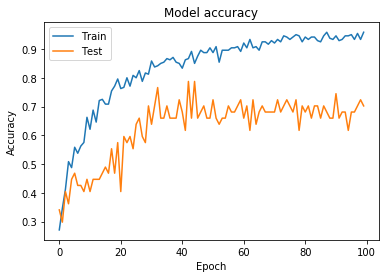

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
ynew = model.predict(X_test)

In [0]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X_test, Y_test, batch_size=1)
print('test loss, test acc:', results)


# Evaluate on test data
288/288 [==============================] - 1s 3ms/sample - loss: 0.7663 - acc: 0.7222
test loss, test acc: [0.7663404682858123, 0.7222222]
